In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
PATH_FILES = 'inputs/'
THRESHOLD_SELEC = 0.6

### Passo 0
Leitura das imagens

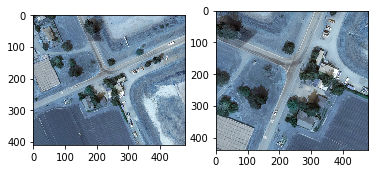

In [3]:
img_a = cv2.imread(PATH_FILES + 'foto4A.jpg')
img_b = cv2.imread(PATH_FILES + 'foto4B.jpg')

plt.subplot(121), plt.imshow(img_a)
plt.subplot(122), plt.imshow(img_b)
plt.show()

### Passo 1
Converter as imagens coloridas de entrada em imagens de níveis de cinza.

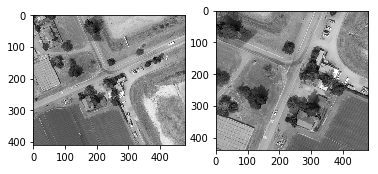

In [4]:
img_gray_a = cv2.cvtColor(img_a, cv2.COLOR_BGR2GRAY)
img_gray_b = cv2.cvtColor(img_b, cv2.COLOR_BGR2GRAY)

plt.subplot(121), plt.imshow(img_gray_a, cmap='gray')
plt.subplot(122), plt.imshow(img_gray_b, cmap='gray')
plt.show()

### Passo 2
Encontrar pontos de interesse e descritores invariantes locais para o par de imagens.

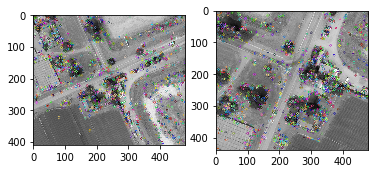

True

In [5]:
# aplicando a tecnica do SIFT
sift = cv2.xfeatures2d.SIFT_create()
# encontra os pontos chaves e os descritores
kp_img_a, des_a = sift.detectAndCompute(img_gray_a,None)
kp_img_b, des_b = sift.detectAndCompute(img_gray_b,None)
# cria copias da imagem original para marcar os descritores
img_sift_a = img_gray_a.copy()
img_sift_b = img_gray_b.copy()
img_sift_a = cv2.drawKeypoints(img_gray_a, kp_img_a, img_sift_a)
img_sift_b = cv2.drawKeypoints(img_gray_b,kp_img_b, img_sift_b)
# plota as imagens com os descritores marcados
plt.subplot(121), plt.imshow(img_sift_a, cmap='gray')
plt.subplot(122), plt.imshow(img_sift_b, cmap='gray')
plt.show()
# salva as imagens
cv2.imwrite('outputs/foto1A-sift.jpeg', img_sift_a)
cv2.imwrite('outputs/foto1B-sift.jpeg', img_sift_b)

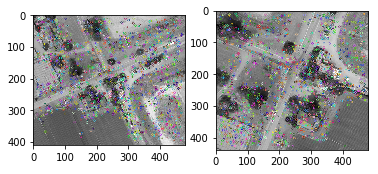

True

In [6]:
# aplicando a tecnica do SURF
surf = cv2.xfeatures2d.SURF_create()
# encontra os pontos chaves e os descritores
kp_surf_img_a, des_surf_a = surf.detectAndCompute(img_gray_a,None)
kp_surf_img_b, des_surf_b = surf.detectAndCompute(img_gray_b,None)
# cria copias da imagem original para marcar os descritores
img_surf_a = img_gray_a.copy()
img_surf_b = img_gray_b.copy()
img_surf_a = cv2.drawKeypoints(img_gray_a, kp_surf_img_a, img_surf_a)
img_surf_b = cv2.drawKeypoints(img_gray_b, kp_surf_img_b, img_surf_b)
# plota as imagens com os descritores marcados
plt.subplot(121), plt.imshow(img_surf_a, cmap='gray')
plt.subplot(122), plt.imshow(img_surf_b, cmap='gray')
plt.show()
# salva as imagens
cv2.imwrite('outputs/foto1A-surf.jpeg', img_surf_a)
cv2.imwrite('outputs/foto1B-surf.jpeg', img_surf_b)

### Passo 3


Computar distâncias (similaridades) entre cada descritor das duas imagens.

In [7]:
# usa o BFMatcher (com parametros default) para encontrar as similaridades
bf = cv2.BFMatcher()
sift_matches = bf.knnMatch(des_a,des_b, k=2)
surf_matches = bf.knnMatch(des_surf_a,des_surf_b, k=2)

### Passo 4
Selecionar as melhores correspondências para cada descritor de imagem.

In [8]:
# para ser considerado um bom match, a distancia m tem q ser menor que 60% da distancia n
sift_selec = []
for m,n in sift_matches:
    if m.distance < THRESHOLD_SELEC * n.distance:
        sift_selec.append(m)
        
print("Numero de matches para o método SIFT: ", len(sift_selec))

Numero de matches para o método SIFT:  326


In [9]:
surf_selec = []
for m, n in surf_matches:
    if m.distance < THRESHOLD_SELEC * n.distance:
        surf_selec.append(m)

print("Numero de matches para o método SURF: ", len(surf_selec))

Numero de matches para o método SURF:  113


### Passo 5
Executar a técnica RANSAC (RANdom SAmple Consensus) para estimar a matriz de homografia (cv2.findHomography).

In [10]:
sift_pts = []
sift_dst = []
if len(sift_selec) > 0:
    for m in sift_selec:
        sift_pts.append(kp_img_a[m.queryIdx].pt)
        sift_dst.append(kp_img_b[m.trainIdx].pt)
        
    sift_M, sift_mask = cv2.findHomography(np.float32(sift_pts).reshape(-1,1,2), np.float32(sift_dst).reshape(-1,1,2), cv2.RANSAC,5.0)

    print("Matriz de homografia encontrada para o metodo SIFT:")
    print(sift_M)
else:
    print("Nao foram encontrados pontos que atendem a correspondencia solicitada!")

Matriz de homografia encontrada para o metodo SIFT:
[[ 1.15520698e+00  1.09404998e+00 -2.19546671e+02]
 [-1.09506519e+00  1.15523958e+00  2.13112166e+02]
 [-1.59585018e-06  1.15417263e-06  1.00000000e+00]]


In [11]:
surf_pts = []
surf_dst = []
if len(sift_selec) > 0:
    for m in surf_selec:
        surf_pts.append(kp_surf_img_a[m.queryIdx].pt)
        surf_dst.append(kp_surf_img_b[m.trainIdx].pt)
        
    surf_M, surf_mask = cv2.findHomography(np.float32(surf_pts).reshape(-1,1,2), np.float32(surf_dst).reshape(-1,1,2), cv2.RANSAC,5.0)

    print("Matriz de homografia encontrada para o metodo SURF:")
    print(surf_M)
else:
    print("Nao foram encontrados pontos que atendem a correspondencia solicitada!")

Matriz de homografia encontrada para o metodo SURF:
[[ 1.14829717e+00  1.09333287e+00 -2.18358097e+02]
 [-1.09573889e+00  1.15305810e+00  2.13477491e+02]
 [-2.08455585e-05  9.99351611e-06  1.00000000e+00]]


### Passos 6 e 7
Aplicar uma projeção de perspectiva (cv2.warpPerspective) para alinhar as imagens e unir as imagens alinhadas e criar a imagem panorâmica.

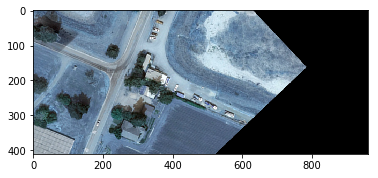

True

In [12]:
img_sift_align_a = cv2.warpPerspective(img_a.copy(), sift_M, ((img_a.shape[1] + img_b.shape[1]), img_a.shape[0]))

plt.imshow(img_sift_align_a)
plt.show()

cv2.imwrite('outputs/foto4-sift-pano.jpeg', img_sift_align_a)

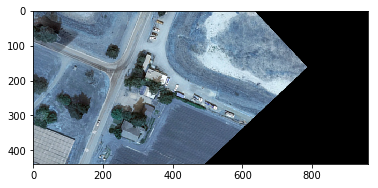

True

In [13]:
img_surf_align_a = cv2.warpPerspective(img_a.copy(), surf_M, ((img_a.shape[1] + img_b.shape[1]), img_b.shape[0]))

plt.imshow(img_surf_align_a)
plt.show()

cv2.imwrite('outputs/foto4-surf-pano.jpeg', img_surf_align_a)

### Passo 8
Desenhar retas entre pontos correspondentes no par de imagens.

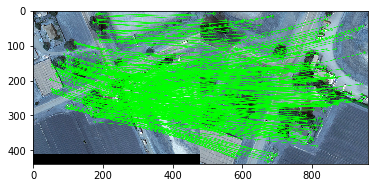

True

In [21]:
draw_params_sift = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = sift_mask.ravel().tolist(), # draw only inliers
                   flags = 2)

sift_lines = cv2.drawMatches(img_a.copy(), kp_img_a, img_b.copy(),kp_img_b, sift_selec, None, **draw_params_sift)

plt.imshow(sift_lines)
plt.show()
cv2.imwrite('outputs/foto4-lines-sift.jpeg', sift_lines)

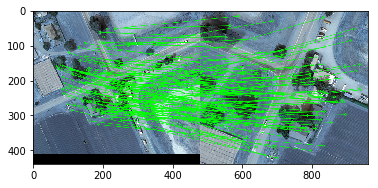

True

In [22]:
draw_params_surf = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = surf_mask.ravel().tolist(), # draw only inliers
                   flags = 2)

surf_lines = cv2.drawMatches(img_a.copy(), kp_surf_img_a, img_b.copy(),kp_surf_img_b, surf_selec, None, **draw_params_surf)

plt.imshow(surf_lines)
plt.show()
cv2.imwrite('outputs/foto4-lines-surf.jpeg', surf_lines)